# Imports

In [1]:
import networkx
import math
import scipy.optimize
import numpy
import sys
from scipy import linalg
import matplotlib.pyplot as plt
from IPython.display import Image
import pywt
import scipy.fftpack
import random
import operator
import copy
from collections import deque
from sklearn.preprocessing import normalize
from sklearn.cluster import SpectralClustering
from matplotlib.lines import Line2D
from lib.io import *
from lib.vis import *
from lib.graph_signal_proc import *
from lib.netpros import *
from lib.syn import *
from lib.experiments import *

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


# Datasets

## Small traffic

In [15]:
small_traffic = {}
small_traffic["path"] = "/home/arlei/Phd/research/network_process/data/small_traffic/"
small_traffic["num_snaps"]=8640

## Large traffic

In [ ]:
traffic = {}
traffic["path"] = "/home/arlei/Phd/research/network-process/data/traffic/"
traffic["num_snaps"]=8640

## Facebook

User activity (send/receive message) on facebook
#vertices: 63392
#snapshots: 
sampling rate: 1 week

In [ ]:
facebook = {}
facebook["path"] = "/home/arlei/Phd/research/network_process/data/facebook/"
facebook["num_snaps"]=227

## Brain

In [ ]:
#TODO

# Karate club

In [ ]:
#G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")

#FT = read_dyn_graph(small_traffic["path"] + "traffic", 2000, G)   

In [ ]:
#plt.clf()
#heatmap = plt.pcolor(numpy.real(FT))
#plt.ylim(0,2000)
#plt.colorbar(heatmap)
#plt.savefig("fourier_time_graph.png")
#Image(filename='fourier_time_graph.png')

## Gaussian noise

In [57]:
G=networkx.karate_club_graph()
syn_Fs = []

for i in range(10):
    syn_F = generate_dyn_gaussian_noise(G, 30)
    syn_Fs.append(syn_F)
    
algs = [SVD(), TwoDHWavelets(), TwoDFourier(), TwoDGNCWavelets()]
reskn = compression_experiment(G, syn_Fs, algs)

/home/arlei/Phd/research/network_process/src/lib/graph_signal_proc.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  F[v] = F[v] + GF[u]*(U.real)[v][u]
/usr/local/lib/python3.4/dist-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


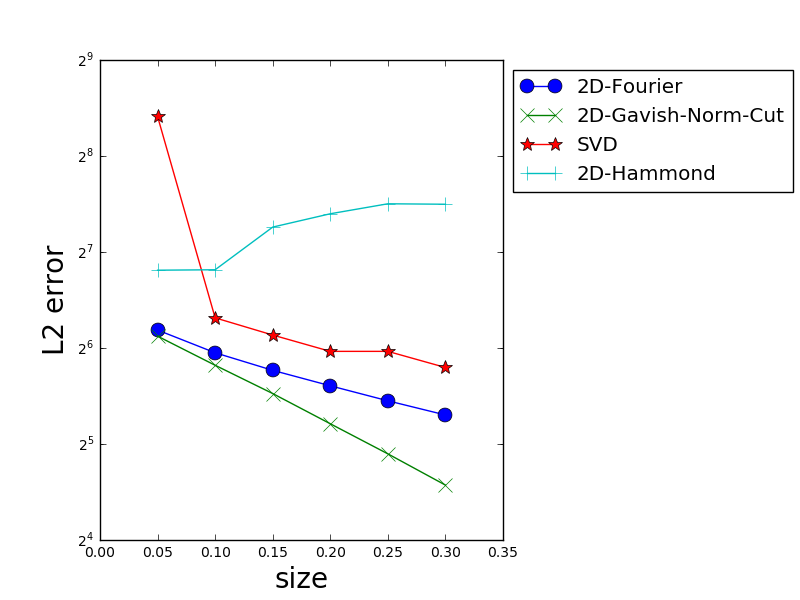

In [5]:
plot_compression_experiments(reskn, "karate_compression_gaussian_noise_l2.png")
Image(filename="karate_compression_gaussian_noise_l2.png")

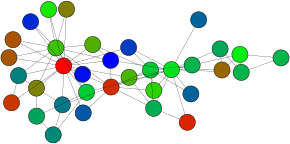

In [58]:
set_f(G, syn_F[-1])

draw_graph_with_values(G, "karate.dot")

!sfdp -Goverlap=prism -Tsvg karate.dot > karate_1.svg

from IPython.display import SVG

SVG(filename='karate_1.svg')

## Heat

In [11]:
G=networkx.karate_club_graph()
syn_Fs = []

for i in range(10):
    syn_F = generate_dyn_heat(G, 5, 1, 10)
    syn_Fs.append(syn_F)
    
algs = [SVD(), TwoDHWavelets(), TwoDFourier(), TwoDGNCWavelets()]
reskh = compression_experiment(G, syn_Fs, algs)

/home/arlei/Phd/research/network_process/src/lib/graph_signal_proc.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  F[v] = F[v] + GF[u]*(U.real)[v][u]
/usr/local/lib/python3.4/dist-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


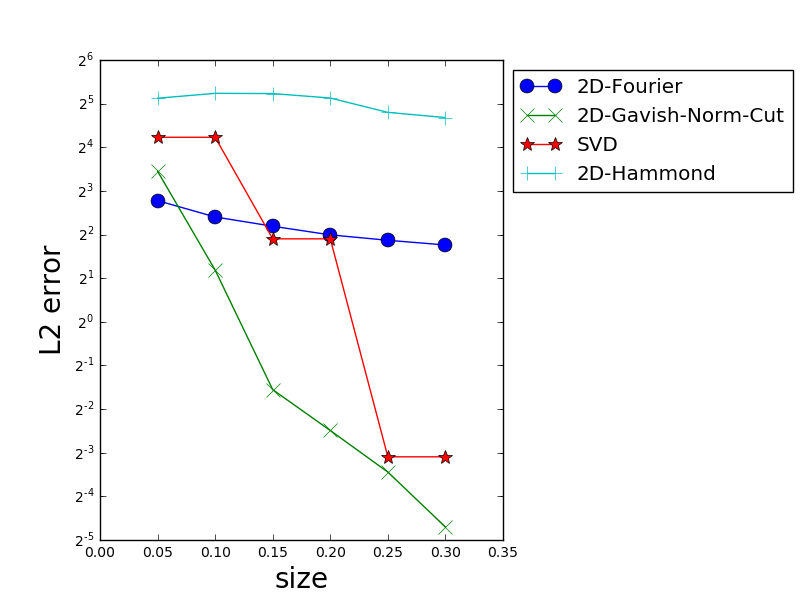

In [12]:
plot_compression_experiments(reskh, "karate_compression_heat_l2.png")
Image(filename="karate_compression_heat_l2.png")

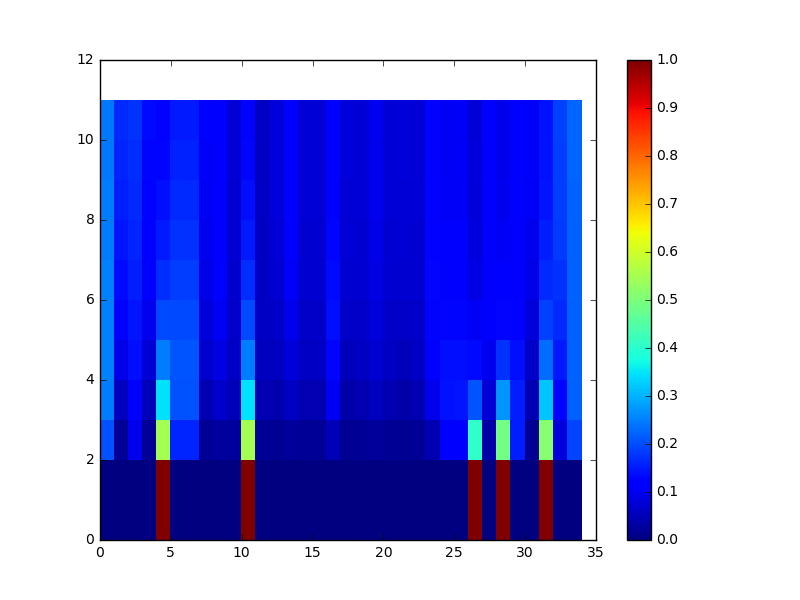

In [13]:
G=networkx.karate_club_graph()
syn_F = generate_dyn_heat(G, 5, 1, 10)
plt.clf()
heatmap = plt.pcolor(syn_F)
plt.colorbar(heatmap)
plt.savefig("karate_sync_bursty.png")
Image(filename='karate_sync_bursty.png')

# Small Traffic

In [46]:
G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")

FT = read_dyn_graph(small_traffic["path"] + "traffic", small_traffic["num_snaps"], G)  

cFT = clean_traffic_data(FT)

## Gaussian Noise

In [18]:
syn_Fs = []
for i in range(10):
    syn_F = generate_dyn_gaussian_noise(G, 100)
    syn_Fs.append(syn_F)
    
algs = [SVD(), TwoDHWavelets(), TwoDFourier(), TwoDGNCWavelets()]
restn = compression_experiment(G, syn_Fs, algs)

/home/arlei/Phd/research/network_process/src/lib/graph_signal_proc.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  F[v] = F[v] + GF[u]*(U.real)[v][u]


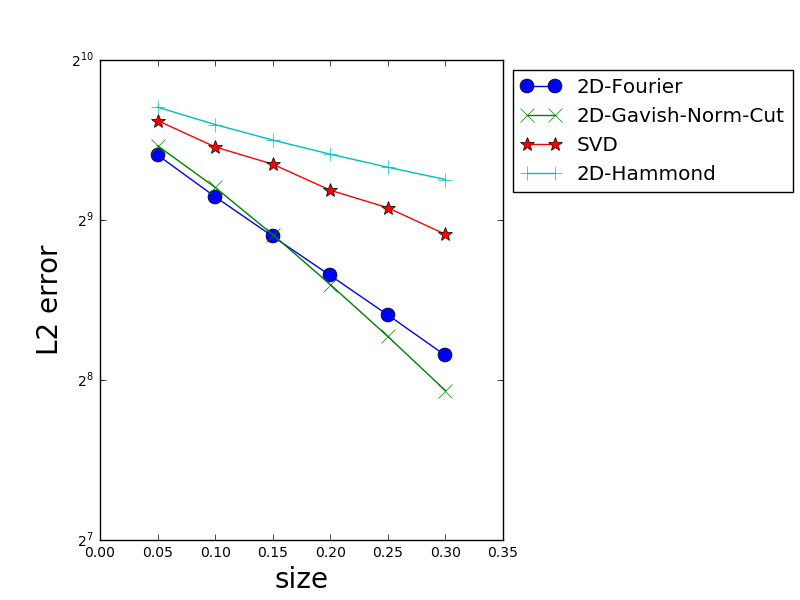

In [19]:
plot_compression_experiments(restn, "traffic_compression_noise_l2.png")
Image(filename="traffic_compression_noise_l2.png")

## Heat

In [71]:
syn_Fs = []
for i in range(10):
    syn_F = generate_dyn_heat(G, 4, 1, 20)
    syn_Fs.append(syn_F)
    
algs = [SVD(), TwoDHWavelets(), TwoDFourier(), TwoDGNCWavelets()]
resth = compression_experiment(G, syn_Fs, algs)

/home/arlei/Phd/research/network_process/src/lib/graph_signal_proc.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  F[v] = F[v] + GF[u]*(U.real)[v][u]
/usr/local/lib/python3.4/dist-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


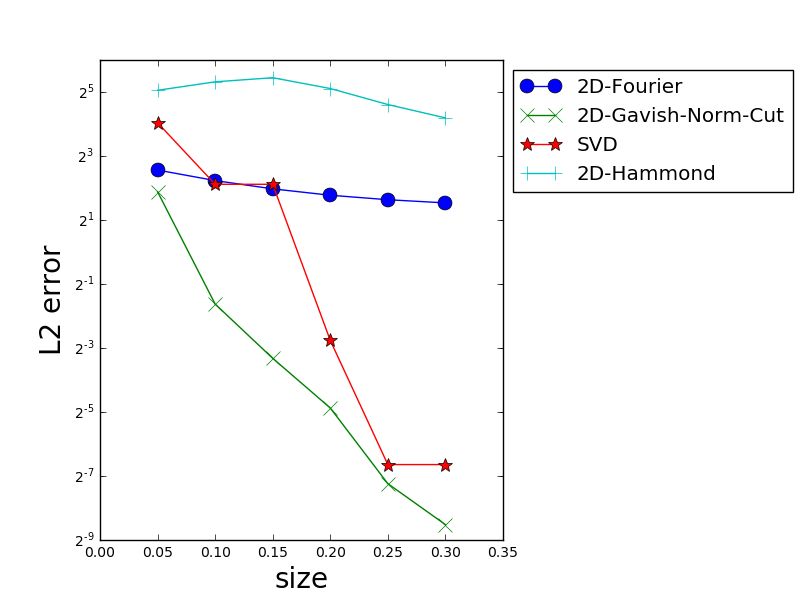

In [72]:
plot_compression_experiments(resth, "traffic_compression_heat_l2.png")
Image(filename="traffic_compression_heat_l2.png")

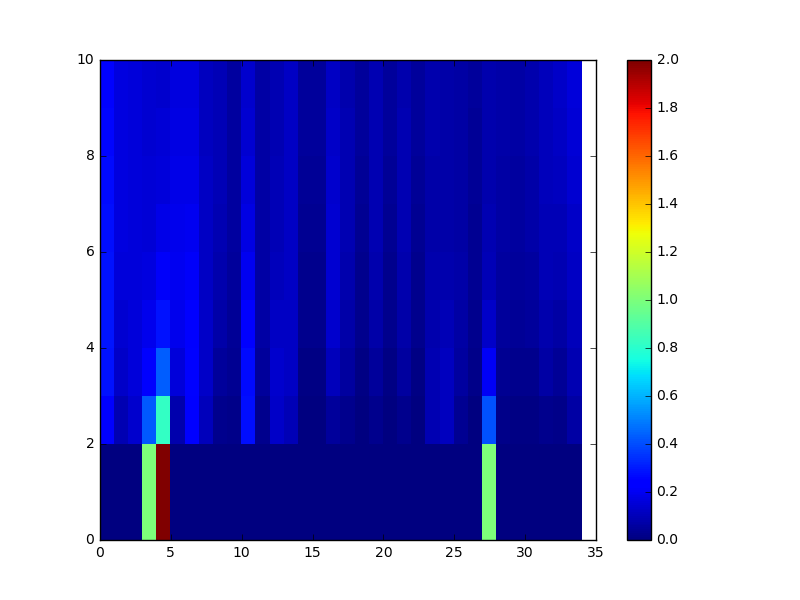

In [70]:
plt.clf()
heatmap = plt.pcolor(syn_F[:10])
plt.colorbar(heatmap)
plt.savefig("karate_heat.png")
Image(filename='karate_heat.png')

In [ ]:
wt = TwoDHWavelets()
wt.set_graph(G)
wtt = wt.transform(syn_F)

In [ ]:
plt.clf()
heatmap = plt.pcolor(wt.scale_energy_info(wtt)[:170])
plt.colorbar(heatmap)
plt.yticks(list(range(0, 170, 34)))
plt.savefig("karate_heat.png")
Image(filename='karate_heat.png')

## Traffic

In [ ]:
G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")
FT = read_dyn_graph(small_traffic["path"] + "traffic", , G)  


In [ ]:
plt.clf()
heatmap = plt.pcolor(numpy.real(FT))
plt.colorbar(heatmap)
plt.savefig("traffic_heat.png")
Image(filename='traffic_heat.png')

In [ ]:
ft = TwoDFourier()
ft.set_graph(G)
ftt = ft.transform(FT)

In [ ]:
plt.clf()
heatmap = plt.pcolor(numpy.absolute(ft.scale_energy_info(ftt)[:50].transpose()[:50]))
plt.colorbar(heatmap)
plt.savefig("traffic_heat.png")
Image(filename='traffic_heat.png')

In [ ]:
wt = TwoDGWavelets()
wt.set_graph(G)
wtt = wt.transform(FT)

In [ ]:
plt.clf()
heatmap = plt.pcolor(numpy.absolute(wt.scale_energy_info(wtt)[:50].transpose()[:50]))
plt.colorbar(heatmap)
plt.savefig("traffic_heat.png")
Image(filename='traffic_heat.png')

In [ ]:
list(range(0,100,10))

In [ ]:
%aimport

In [ ]:
print (reskh)

In [ ]:
print(list(Line2D.markers.keys()))

In [ ]:
tree, ind = normalized_cut_hierarchy(G)

In [ ]:
G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")

A = networkx.adjacency_matrix(G)
spectral = SpectralClustering(n_clusters=5, affinity='precomputed')
f = spectral.fit(A)
C = spectral.fit_predict(A)

In [ ]:
Gc = max(networkx.connected_component_subgraphs(G), key=len)
print (Gc.edges())

In [ ]:
A = networkx.adjacency_matrix(G)
spectral = SpectralClustering(n_clusters=2, affinity='precomputed')
f = spectral.fit(A)
C = spectral.fit_predict(A)

In [ ]:
set_f(G, C)
draw_graph_with_values(G, "karate.dot")

!sfdp -Goverlap=prism -Tsvg karate.dot > karate_1.svg

from IPython.display import SVG

SVG(filename='karate_1.svg')

In [ ]:
import statsmodels.api as sm
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

In [ ]:
import pandas as pd
from datetime import datetime, date, time, timedelta
G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")
FT = read_dyn_graph(small_traffic["path"] + "traffic", small_traffic["num_snaps"], G)
start_time = datetime.strptime("1/04/11 00:00", "%d/%m/%y %H:%M")
data = pd.DataFrame(FT[:,0], pd.DatetimeIndex(start='1/04/11 00:00',
                                                 periods=len(FT[:,0]),
                                                 freq='5min'))

In [ ]:
data.interpolate(inplace=True)

In [ ]:
res = sm.tsa.seasonal_decompose(data.values, freq=2016)

In [ ]:
resplot = res.plot()
plt.show()

In [ ]:
numpy.nan_to_num(res.trend)+numpy.nan_to_num(res.res)

In [ ]:
print (sm.datasets.co2.load_pandas().data)

In [ ]:
G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")
FT = read_dyn_graph(small_traffic["path"] + "traffic", small_traffic["num_snaps"], G)
cFT = clean_traffic_data(FT)

In [ ]:
plt.clf()
heatmap = plt.pcolor(cFT)
plt.colorbar(heatmap)
plt.savefig("traffic_heat.png")
Image(filename='traffic_heat.png')

In [ ]:
plt.clf()
heatmap = plt.pcolor(numpy.real(FT))
plt.colorbar(heatmap)
plt.savefig("traffic_heat.png")
Image(filename='traffic_heat.png')

In [ ]:
G = read_graph(facebook["path"] + "facebook.graph", facebook["path"] + "facebook_100.data")
FT = read_dyn_graph(facebook["path"] + "facebook", facebook["num_snaps"], G)  

In [ ]:
algs = [TwoDGNCWavelets()]

restf = compression_experiment(G, [FT], algs)

In [ ]:
FT[1]